In [2]:
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm 
import json
import os
import datetime
import re
import glob
import csv
import time
import pandas as pd
from nltk.stem import *
from collections import Counter
from functools import reduce
import numpy as np

#Used to clean the data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import tokenize

#Modules used to plot the graph
import seaborn as sns
import matplotlib.pyplot as plt

#import datatable as dt   
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#To read and store dictionary
import pickle

#our functions used in the files
from functions import *

#Modules used to plot the graph in ex 4
import geopy
from geopy.geocoders import Nominatim



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data collection

## 1.1. Get the list of places

The "getLinks" function can be seen in the "functions.py" file with its source code along with line-by-line comments. Below is a brief explanation of how it works <br>

The "getLinks" function works in this way. We noticed the fact that the link on the page atlasobscura.com is indexed in such a way that it is possible to extract the various links with an incremental variable. We take this variable and iterate over a range decided by us. For each iteration we join the variable along with the standard string describing the site path.  In this way we get the path we were looking for. We save it to us in a list named "total_link" and at the end we return the list.

This is just one of the possible methods for extracting the various links, in fact another possibility was to fetch us the link to the next page by going there and extracting the link directly from the buttons on the previous page

The reason why we use "requests.Session()" instead of the normal "request" will be explained later

In [ ]:
#Ex with range going from 1 to 9
total_link = getLinks(1,10)

We decided to save the list for ourselves in order to access its contents without avoiding having to perform link extraction each time

In [ ]:
f = open('total_link.txt',"r")
total_link = f.read().split("\n")

## 1.2. Crawl places

The "downloadPage()" function can be seen in the functions.py file, with its comments line by line. Below is a brief explanation of its operation.

The function takes as input a starting point, an end point, and the array containing the paths to the pages to be downloaded in .html format.
It first establishes a session. then for each page in the range given via "start" and "finish," it takes the relevant url path and makes a request to the site to download the whole page. The .html file will be downloaded into the appropriate folder.

#### Regarding the efficiency of the function, some techniques were applied to try to make the process more optimized.

First of all, by using only the "requests.get()" method to make requests to the site, a session is established each time, which is later dropped after sending the packet containing our request. To prevent the session from being closed each time, we decided to create it ourselves and keep it active by refreshing it every 10 pages (=180 links). <br>
Another possible action that could have increased the efficiency of this function is through the application of the concept of paralelization. Currently, requests to the site occur sequentially, this means that only one request at a time is sent to the atlasobscura site. It would also have been possible to make multiple requests simultaneously to reduce the execution time

Translated with www.DeepL.com/Translator (free version)

In [ ]:
downloadPage(0, 400, total_link)

## 1.3 Parse downloaded pages

The "downloadTSV" function is visible in the functions.py file. Below is a brief explanation of its operation.

The function groups many small subfunctions that each perform the task of extracting an attribute from the html page.

The function is structured like this.

DownloadTSV:
- FindPLaceName()
- findPlaceTags()
- findNumPeopleVisited()
- findNumPeopleWant()
- findDescription()
- findShortDescription()
- findNearbyPlaces()
- findAddress()
- findCordinates()
- findPostEditors()
- findPublishingDate()
- findPlaceNear()
- findRelatedPlaces()
- findPageURL()

For every files in the directory "all_pages/*" the function will extract the information metioned above and will save the file as a tabular file (tab separated).

## Load all the tsv file into one pandas dataframe

We decided to save all the .tsv file as one joined .csv where every file rappresents one row of the .csv file, so that we can work and access the data without having to read 7200 tsv file each time. The data are stored in the "tsv_dataframe.csv"

This mean that the function load_tsv() has only been executed once. The other iteration we just read the .csv file

In [ ]:
#This cell has only been executed once, just to make the first merged dataframe of .tsv files
#From this point onwards we will read the file directly from the directly
tsv_dataframe = load_tsv()

In [2]:
# data = load_tsv()
data = pd.read_csv("tsv_dataframe.csv",index_col=0)

#Reset Index
data.reset_index(inplace = True, drop=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   placeName          7200 non-null   object 
 1   placeTags          7166 non-null   object 
 2   numPeopleVisited   7200 non-null   int64  
 3   numPeopleWant      7200 non-null   int64  
 4   placeDesc          7200 non-null   object 
 5   placeShortDesc     7200 non-null   object 
 6   placeNearby        7200 non-null   object 
 7   placeAdress        7166 non-null   object 
 8   placeAlt           7200 non-null   float64
 9   placeLong          7200 non-null   float64
 10  placeEditors       7194 non-null   object 
 11  placePubDate       7199 non-null   object 
 12  placeRelatedList   7199 non-null   object 
 13  placeRelatedPlace  7166 non-null   object 
 14  placeURL           7200 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 843.9+ KB


In [4]:
data.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedList,placeRelatedPlace,placeURL
0,City Hall Station,"subways,subterranean,infrastructure,subterrane...",1834,8603,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"The Sugar House Prison Window,Tunnel Number 3,...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"Rebekah Otto,Annetta Black,Allan,charding407,w...",2010-05-08 00:00:00,"African Burial Ground National Monument,Tunnel...","Crystal Palace Subway,Moscow Metro Stations,Ro...",https://www.atlasobscura.com/places/city-hall-...
1,The Winchester Mystery House,"follies and grottoes,outsider architecture,ecc...",3723,5209,In 1886 an eccentric woman named Sarah Winches...,A peculiar mansion built by the troubled heir ...,"Rosicrucian Park,Rosicrucian Egyptian Museum,S...","525 South Winchester Boulevard San Jose, Calif...",37.3189,-121.9506,"mbison,Avoiding Regret,PrestonW,Collin,Destina...",2008-11-21 00:00:00,"Santana Row Chess Plaza,Rosicrucian Park,Rosic...","Casa de Piedra (Stone House),Portmeirion Villa...",https://www.atlasobscura.com/places/winchester...
2,Center for Puppetry Arts,"sesame street,puppets,museums",705,1027,"If you know your Gonzo from your Gelflings, yo...",The largest puppetry museum in the USA houses ...,"Breman Museum,The Consulate,Atlanta Monetary M...","1404 Spring St Atlanta, Georgia United States",33.7927,-84.3896,"kendallmbailey,Martin,andydoesit,We All Pod Do...",2018-11-12 00:00:00,"Breman Museum,Atlanta Monetary Museum,The Cons...","Portland Puppet Museum,Museu da Marioneta (Mus...",https://www.atlasobscura.com/places/center-for...
3,Amityville Horror House,"hoaxes and pseudoscience,haunted,film location...",367,831,"On a cold November night in 1974, Amityville, ...",The site of a tragic massacre that spawned a m...,"The Long Island Puppet Theater,Pilgrim Psychia...","112 Ocean Avenue Amityville, New York, 11701 U...",40.6665,-73.4143,"EricGrundhauser,MandrewPatinkin,lendog666,Mart...",2013-10-17 00:00:00,"The Long Island Puppet Theater,Fire Island Lig...","Conanicut Island Lighthouse,Lovell Health Hous...",https://www.atlasobscura.com/places/amityville...
4,Yuma Territorial Prison,"prisons,crime and punishment",422,833,"On July 1, 1876, the first seven inmates enter...",Walk through the actual strap iron cells and s...,"Valley of the Names,Felicity, California: Cent...","1 Prison Hill Rd Yuma, Arizona, 85364 United S...",32.7266,-114.6144,"desertfairy,mbison,CorpseLady84,Avoiding Regre...",2010-04-01 00:00:00,"Felicity, California: Center of the World,Vall...","Buckley's Cave,Palazzo d'Avalos,Oxford Castle ...",https://www.atlasobscura.com/places/yuma-terri...


In [6]:
#data2 will be used for the EDA
data2 = data.dropna(subset = ["placePubDate"])
data2 = data2.dropna(subset = ["placeEditors"])

#Let's clean the dataframe from the na values
data = data.fillna("")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   placeName          7200 non-null   object 
 1   placeTags          7200 non-null   object 
 2   numPeopleVisited   7200 non-null   int64  
 3   numPeopleWant      7200 non-null   int64  
 4   placeDesc          7200 non-null   object 
 5   placeShortDesc     7200 non-null   object 
 6   placeNearby        7200 non-null   object 
 7   placeAdress        7200 non-null   object 
 8   placeAlt           7200 non-null   float64
 9   placeLong          7200 non-null   float64
 10  placeEditors       7200 non-null   object 
 11  placePubDate       7200 non-null   object 
 12  placeRelatedList   7200 non-null   object 
 13  placeRelatedPlace  7200 non-null   object 
 14  placeURL           7200 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 843.9+ KB


Our dataframe contains some NA values, in particulary in the informations "Place Tags", "Place Adress", "Place Related Place" (34 NA values each), anyway for our analysis we care about the place editors (6 NA) and the Place Pubblice Date (1 NA) replacing this values to make our analysis possibile.

# 1.5 EDA

The following work carries forward a study of data from the "Atlas Obscura" website, an American online magazine and travel firm, catalogues unusual and obscure tourist locations. We considered 7200 touristic attractions around the world (rows of the dataframe) for a total of 15 informations (the columns). The goals of the project are to create two search engine, define a new score, visualize in a map the most relevant places etc. but first of all let's have a look with an exploratory data analysis (EDA) in our data.

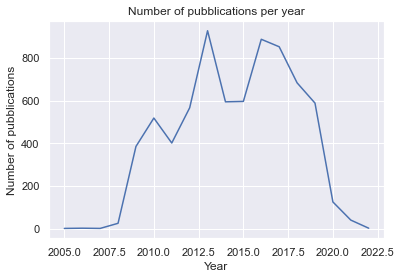

The year with more pubblications: 2013
Total number of pubblications in that year: 927


In [8]:
data2.placePubDate
data2.placePubDate2 = pd.to_datetime(data2.placePubDate)
data2['year'] = data2.placePubDate2.dt.year
conteggio = data2['year'].astype(int)
conteggio = conteggio.value_counts(dropna=True)

sns.set_theme()
grafico1 = sns.lineplot(data=conteggio, palette = "plasma")
grafico1.set(xlabel = "Year", ylabel = "Number of pubblications", title = "Number of pubblications per year")
plt.show()
print("The year with more pubblications:", data2['year'].value_counts().idxmax())
print("Total number of pubblications in that year:", data2['year'].value_counts()[2013])

Atlas Obscura was born in 2009, with the firsts pubblications goes up to the previous years. The data we have considered tell us that the peak of publications can be identified in 2013 when 887 places have been registred. In the last years, instead, the number of pubblications decresed. Perhaps the covid-19 pandemic affected not only travels but also travel-related publications.

In [7]:
data2.describe().applymap('{:,.2f}'.format)

,numPeopleVisited,numPeopleWant,placeAlt,placeLong
count,"7,193.00","7,193.00","7,193.00","7,193.00"
mean,418.87,913.72,40.19,-55.61
std,530.32,666.85,12.47,62.71
min,12.00,406.00,-77.72,-168.06
25%,133.00,522.00,35.99,-97.74
50%,247.00,691.00,40.73,-77.04
75%,479.00,"1,038.00",46.07,-1.16
max,"6,639.00","8,603.00",78.24,176.39


The average of people (that belong to the Atlas Obscura community) that visited a site is 418.87, instead the average of people that would like to visit a precise site is 913.72. Interesting is the information about the minimum (12 for "numPeopleVisited" and 406 for "numPeopleWant"): infact the value in the variable "number of people want" is much bigger than "number of people visited". What can be deduced is that even a touristic location that is very unknown and rarely visited create a lof of curiosity in the travelers. 

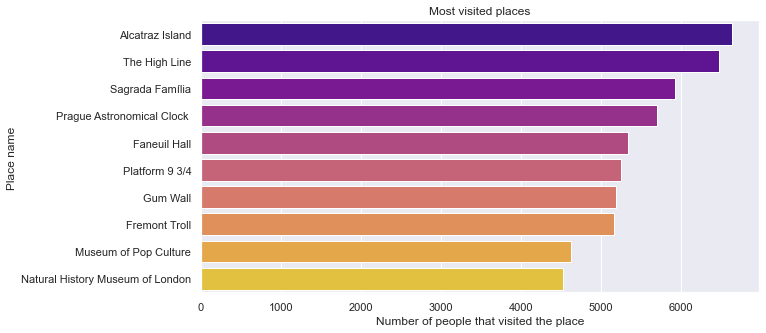

In [13]:
top_meta = data2.sort_values(["numPeopleVisited"], ascending = False).head(10)
plt.figure(figsize=(10,5))
grafico3 = sns.barplot(x = top_meta.numPeopleVisited,y = top_meta.placeName, palette="plasma")
grafico3.set(xlabel = "Number of people that visited the place", ylabel = "Place name ", title = "Most visited places")
plt.show()

Different it's the situation for the Most desidered places. In fact, they don't match with the most visited places. At the first place there is the City Hall Station in New York with 8603 people that want to go there, at the second place there is the Highgate Cemetery in London which is in the favourite places of 8206 people. At the third place there is the Leadenhall Market in London with 7593 units.

The mismatch between the most visited and most desired places leads us to study the correlation between these two variables.

Pearson correlation:  0.4638404488887379


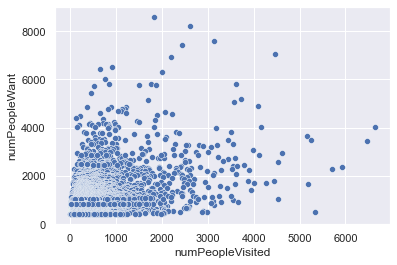

In [14]:
var1 = data2.numPeopleVisited
var2 = data2.numPeopleWant
print("Pearson correlation: ", var1.corr(var2, method = "pearson"))
grafico4 = sns.scatterplot(x="numPeopleVisited", y="numPeopleWant", data=data2, palette = "plasma");
plt.show()

Pearson's correlation index is low  (0.46), so there is not a strong liner correlation on average between the two variables and a weak linear dependence.

In [15]:
keys, values = findTop(data2, "placeEditors")

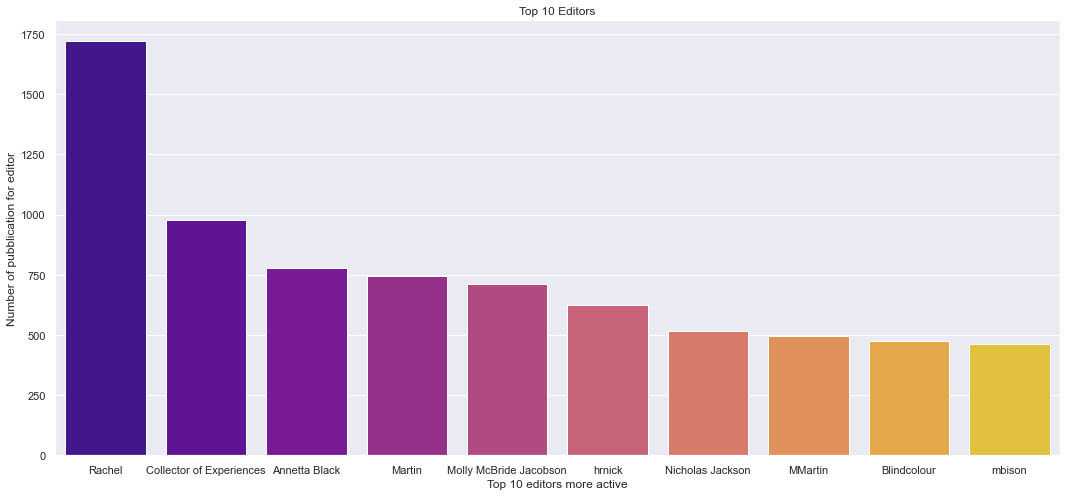

In [17]:


plt.figure(figsize=(18,8))
grafico5 = sns.barplot(x = keys,y = values, palette="plasma")
grafico5.set(xlabel = "Top 10 editors more active", ylabel = "Number of pubblication for editor", title = "Top 10 Editors")
plt.show()

This barplot represent the top 10 editors (the people that writed more publications in the website). The first place belong to "of" (1041), the second to "McBride" (713) and the third to "Black" 269. The first two editors can be considered outliers because they have a very high number of publications compared to other editors.

In [18]:
keys, values = findTop(data2, "placeTags")

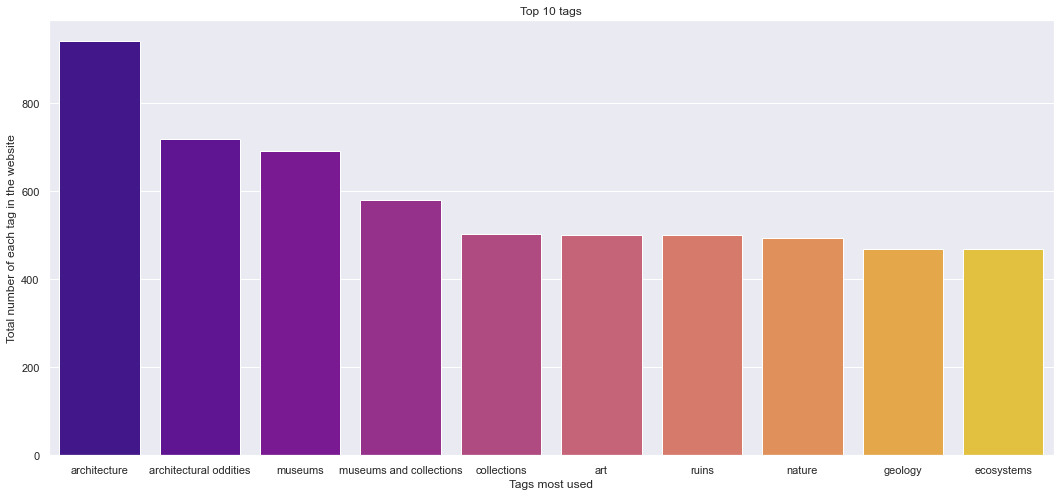

In [19]:

plt.figure(figsize=(18,8))
grafico6 = sns.barplot(x = keys,y =  values, palette="plasma")
grafico6.set(xlabel = "Tags most used", ylabel = "Total number of each tag in the website", title = "Top 10 tags")
plt.show()

In the end of this analysis, collecting all the tags on the site, is viewable that architecture is the topic with more places in the website (942), after, more in particular, there are architectural oddities (720), and later museums (692).

# 2. Search Engine

Before starting the search engines, since we'll look for words in the descriptions of each place, we clean the collected placeDesc for every place in the dataset.  
In order to have later a more readable output we'll not sobsitute the column placeDesc with the one with all the cleaned descriptions but we'll add another column to our dataset 'data'.   
In particular the function *cleaning*, that we apply in the next cell at every description, will:
- convert all the upper characters in lower ones;
- remove all the punctuations;
- remove all the stopwords;
- remove all numbers;
- stem the string.

Let's create a new column with the clean descriptions:

In [ ]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanDesc'] = data.placeDesc.apply(lambda row: " ".join(cleaning(row)))

Now we save the data as a .csv file for future uses so that we don't need to run again the previous cell.

In [ ]:
data.to_csv("dataframe_clean.csv")

Run the following cell if you want the original dataframe with a column 'cleanDesc' with the cleaned description.

In [3]:
data = pd.read_csv("dataframe_clean.csv")
data.fillna('', inplace=True)

## 2.1 Conjunctive query

### 2.1.1 Create your index!

The next function *createFirstDic*, given the dataset 'data', will return the dictionary *vocabulary* .     
Vocabulary will be such that every key is a unique word contained in the descriptions and its corresponing value is an integer that identifies that word.

In [79]:
def createFirstDic(data: pd.DataFrame, nameCol: str) -> dict:
    # first we create an empty dictionary
    dic = {}
    value = 1
    for description in tqdm(data[nameCol]):
        for word in description.split():
            # if the word is already in the dictionary keys this mean that it has already even a corresponding number and
            # so we can skip to the next word in the fixed description
            if word in dic.keys():
                continue
            # otherwise we create a new key named 'word' with value = value and then we upgrade value
            else:
                dic[word] = value
                value += 1
    return dic

We can now call the function createFirstDic and store its output as *vocabulary*:

In [ ]:
vocabulary = createFirstDic(data, "cleanDesc")

The second dictionary that we'll need for the first search engine is *inverted index* that is such that every key is an integer that identifies a word and its corresponding value is a set of all the document_id that contain that word.    
The following function *createSecondDic*, given as input the dataset 'data' and the dictionary 'vocabulary', will return the *inverted index* dictionary.  

In [80]:
def createSecondDic(data: pd.DataFrame, vocabulary: dict, nameCol: str) -> dict:
    dic = {}
    # a will keep track of the row index of the data
    a = 0
    # we take one description at a time from the column 'cleanDesc'
    for description in tqdm(data[nameCol]):
        # for every word in the fixed description 
        for word in description.split():
            # if the corresponding integer of the word is already in the keys of the inverted_index then we need to
            # add the document_id of the fixed description to the already existing set
            if vocabulary[word] in dic.keys():
                dic[vocabulary[word]].add(data.placeName[a])
            # otherwise we create a new key named as the corresponding integer of the word with value equal to a set that 
            # contains the document_id of the fixed description
            else:
                dic[vocabulary[word]] = set([data.placeName[a]])
        a += 1
    return dic

We can now call the function createSecondDic and store its output as *inverted_index*:

In [ ]:
inverted_index = createSecondDic(data,vocabulary, "cleanDesc")

Even in this case we can store the two dictionary in a separate file so that we don't need to run the codes everytime we need them.

In [ ]:
save_dic(vocabulary, "vocabulary")
save_dic(inverted_index,"inverted_index")

Run the following cell if you want the dictionaries *vocabulary* and *inverted_index*.

In [21]:
vocabulary = read_dic("vocabulary")
inverted_index = read_dic("inverted_index")

### 2.1.2 Execute the query

First of all we ask the user which query do we have to look for in the places descriptions and we store it as a string named *q*:

In [22]:
q = input('Insert the query that you want to find in the places descriptions: ')

Before starting the first search engine with the query *q* we need to clean q too.

In [23]:
q = cleaning(q) 
# now q is a list that contains the cleaned word of the input query
print(q)

['american', 'museum']


The next function *query* is our first search engine that, given as input a list of words (the query), it will return as output a list of all the documents_id that contain all the words in the list.

In [24]:
def query(list, vocabulary, inverted_index):
    # s is the set of the documents_id that contain the first word in the query
    s = inverted_index[vocabulary[list[0]]]
    # starting from the second word in the query till the last we'll intersect the set s with the set of all the documents_id 
    # that contain the fixed word 
    for x in range(1, len(list)):
        s.intersection(inverted_index[vocabulary[list[x]]])
    return s

We can now execute the previous function with our query q:

In [25]:
s = query(q,vocabulary,inverted_index)
# s is the set with all the documents_id of all the descriptions that contain all the words in the query

We can now create a new dataset *res_query* with just the places we're interested in:

In [26]:
res_query = data[data['placeName'].isin(list(s))]

With the following code we'll show the result of the first search engine.    
In particular we'll show just the places names, their description and their URL.

In [29]:
res_query[['placeName','placeDesc','placeURL']].head(5)

,placeName,placeDesc,placeURL
3,Amityville Horror House,"On a cold November night in 1974, Amityville, ...",https://www.atlasobscura.com/places/amityville...
6,American Prohibition Museum,When the 18th Amendment to the U.S. Constituti...,https://www.atlasobscura.com/places/american-p...
13,Wild Blueberry Land,There is no shortage of bizarre American highw...,https://www.atlasobscura.com/places/wild-blueb...
39,The Avrocar,The year was 1952 and the Cold War was in full...,https://www.atlasobscura.com/places/avrocar
59,Laurel Dinosaur Park,"During the 18th and 19th centuries, clay forma...",https://www.atlasobscura.com/places/laurel-din...


## 2.2 Conjunctive query & Ranking score

### 2.2.1 Inverted index

Now we have to create another dictionary *inverted_index_2* in which we store also the *tfidf* values of the words.   
As suggested, since the tfidf are invariant for the query we can precalculate them before and store them in a dataframe *df*.    
In order to do this we use the module *TfidfVectorizer* that is able to compute the tfidf values of all the unique words in the places descriptions.

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, analyzer='word',sublinear_tf=True)
x =vectorizer.fit_transform(data["cleanDesc"]).todense()
df = pd.DataFrame(x, columns = vectorizer.get_feature_names_out())

*df* now is a dataframe such that every row corresponds to a place's description and every column corresponds to a word found in the descriptions.    
Using now *df* and the two dictionary previously created, we can now create *inverted_index_2* that will be such that every key is an integer that corresponds to a word and its value is a list of touples (document_id, tfidf{word,document_id}).

In [ ]:
def createInvertedIndex(data, vocabulary, nameCol, matrix):
    inverted_index2 = {}
    # for every word in columns name of df
    a = 0
    for word in tqdm(matrix.columns):
        # we fix a row in df that correspond to a place's description
        for place in matrix.index:
            # if in the keys of our dictionary there already is the integer that corresponds to our word then we just have to 
            # add a tuple to our existing set with the placeName and the tfidf score of that word in the fixed description
            if vocabulary[word] in inverted_index2.keys() and matrix[word][place] != 0:
                inverted_index2[vocabulary[word]].add((data[nameCol][place], matrix[word][place]))
            # otherwise we can add a new key with value a set that contains a tuple (placeName,tfidf{word,placeName})
            else:
                inverted_index2[vocabulary[word]] = set((data[nameCol][place], matrix[word][place]))           
    return inverted_index2

We can now execute the previous function with as input our *data*, *vocabulary* and *df*:

In [ ]:
inverted_index_2 = createInvertedIndex(data, vocabulary, "cleanDesc", df)

As previously done with the other two dictionary, we store *inverted_index_2* in a separate file so that we don't have to compute it again.

In [ ]:
save_dic(inverted_index_2, "inverted_index_2")

Run the following cell if you want the dictionariy *inverted_index_2*.

In [30]:
inverted_index_2 = read_dic("inverted_index_2")

### 2.2.2) Execute the query

Since later we'll need again to compute cosine similarity between a query given by the user and a column of our dataframe *data* we've decided to create a generic function that is able to:
- find the matrix of *tfidf* scores of  the query and the words in a given column of *data* (*nameCol*);
- create the dictionary *vocabulary* and *inverted_index* with words in *nameCol*;
- look for all the places that contain the words in the query in *nameCol*;
- compute the cosine similarity;
- sort the dataframe by the cosine similarity.

The functions ***"query_tfidf()"*** and ***"cosine_score"*** can be seen in the file function.py

The function "query_tfidf()" is the function responsible for executing exercise 2.2 in full. First, via TfidfVectorizer we create our matrix for the tfidf score of each column, i.e., word, for each row, i.e., document.<br>
Next we call the query function on the string you selected, filter all the results useful for our search, and then calculate the cosine similarity. That will be used to sort the result of our query

The function ***cosine_score*** given *res_query*, *df* and *qv* is able to compute the cosine similarity of the places descriptions with respect to the query.    
Let's remark what is the cosine similarity of a description to a query:
$$cosine similarity = \frac{sentence\cdot query}{\Vert sentence\Vert  \Vert query\Vert}$$
where *sentence* is the tfidf vector of the given sentence and *query* is the tfidf of the query.

Finally we can ask the user the query he wants to find in the places descriptions and execute the function *query_tfidf*:

In [32]:
q = input('Insert the query that you want to find in the places descriptions: ')
final_query = query_tfidf(data, "cleanDesc", q, vocabulary, inverted_index)
final_query[['placeName','placeDesc','placeURL','CS_cleanDesc']].head(5)

,placeName,placeDesc,placeURL,CS_cleanDesc
4563,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manha...",https://www.atlasobscura.com/places/self-taugh...,0.181039
605,Renwick Gallery,The Renwick Gallery building has the distincti...,https://www.atlasobscura.com/places/renwick-ga...,0.180539
2216,American Writers Museum,The American Writers Museum—tucked away on the...,https://www.atlasobscura.com/places/american-w...,0.176558
2585,Mount Angel Abbey Museum,The Mount Angel Abbey Museum is a very eclecti...,https://www.atlasobscura.com/places/mount-ange...,0.168144
4413,The American Pigeon Museum,"Many people, especially in big cities, view pi...",https://www.atlasobscura.com/places/the-americ...,0.167326


# 3. Define a new score!

Our idea is to create a new score based on the number of people who have already been in a place or on the number of people who want to see that place. 
First we let the user insert the query that he want to search in the places descriptions.   
Then we let the user choose the number of places he wants to see in the final output and if he wants to sort the places by the scores of *numPeopleVisited* or of *numPeopleWant*.  
As last input we ask the user if he wants to see the most popular ones or the least.

In [66]:
q = input("Insert the words that you want to be found in the description's places: ")

As before, the first thing that we do is to clean the query:

In [67]:
q = cleaning(q) 
# now q is a list that contains the cleaned word of the input query
print(q)

['church']


Then we execute the first search engine as in 2.1 with the query given by the user:

In [68]:
s = query(q,vocabulary,inverted_index)
res_query = data[data['placeName'].isin(list(s))]
res_query.reset_index(inplace = True, drop=True) 

Now we can ask the user which type of score he wants and store the choice in a variable *n*

In [69]:
n = int(input('What is the top rank visualization that you want to have? \nInsert "1" if you prefer that is by number of tourists. \nInsert "2" if you prefer that is by number of people that want to visit the site.\n'))

Then we can ask to insert the number of places he wants to see (*k*) and if he wants to see the most popular or the least (*m*):

In [70]:
k = int(input('Insert k the number of places that you want to visualize:')) 
m = int(input('Insert "1" if you want to see the k most popular places or insert "2" if you want to see the less famous places:'))

The function new_score will return the result of the query. The function itself can be visible in the "functions.py" files. Following is a brief explaination of the function execution.
Given the places that contains all the words in the query and the choices made by the user (*n*, *k*, *m*) this function will compute the proper new score. The new score will be calculated as the *numPeopleVisited* or *numPeopleWant* divided by the max value in the same column in the dataframe *res_query*. At the end of the function we sort by this new score (in ascending or descending order depending on the user's choice) and return the ordered res_query.

We can now execute the *new_score* function and print the first *k* element of the final dataframe:

In [71]:
resquery = new_score(res_query,n,k,m).head(k)
resquery[['placeName','placeDesc','placeURL','scores']]

,placeName,placeDesc,placeURL,scores
15,Sagrada Família,When the foundation stone of the Basílica i Te...,https://www.atlasobscura.com/places/sagrada-fa...,1.0000
401,Hallgrimskirkja,Rising 244 feet above the streets of Reykjavik...,https://www.atlasobscura.com/places/hallgrimsk...,0.6073
467,Boston's Old Burying Grounds,"“Stay! thou this tomb that passeth by, And thi...",https://www.atlasobscura.com/places/boston-s-o...,0.5504
154,Old North Church,The Old North Church is a national historic la...,https://www.atlasobscura.com/places/old-north-...,0.5269
60,One Times Square,Marooned on a triangular intersection at the h...,https://www.atlasobscura.com/places/one-times-...,0.4388
382,Whispering Gallery at St Paul’s Cathedral,In the walkway that circles the inside of Chri...,https://www.atlasobscura.com/places/whispering...,0.4208
95,Trinity Churchyard,Now dwarfed by the surrounding Wall Street sky...,https://www.atlasobscura.com/places/trinity-ch...,0.3995
538,Speakers' Corner,Free speech laws in the United Kingdom include...,https://www.atlasobscura.com/places/speakers-c...,0.3726
481,Santa Maria della Concezione Crypts,"In 1775, the Marquis de Sade wrote of it, “I h...",https://www.atlasobscura.com/places/santa-mari...,0.3498
556,Notre Dame Basilica,The Notre Dame Basilica is anything but ordina...,https://www.atlasobscura.com/places/notre-dame...,0.3440


# 4 - Visualizing the most relevant places

The idea is to create a map to visualize better all the places selected by the query in exercise 3. In the map all the placed will be represented by points with different colors by continent.

Hovering the pointer over each place will display the name, city, address, country and the number of people that visited that place.

In [72]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [73]:
#To begin we reset the index for the k places and we create two lists (city, country)
resquery.reset_index(inplace = True, drop=True)
city=[]
country=[]

for i in range(resquery.shape[0]):
    # this for cicle will iterate all the places saving in lat and long the latitude and longitude
    lat = resquery.placeAlt[i]
    lon = resquery.placeLong[i]
    # geolocator is a library that is able to take the address, city and country giving the latitude and logitude.
    location = geolocator.reverse(str(lat)+","+str(lon))
    address = location.raw['address']
    city.append(address.get('state', ''))
    country.append(address.get('country', ''))
    
    
# reach this point we create two columns with the city/state and country
resquery.insert(resquery.shape[1], "city/state", city)
resquery.insert(resquery.shape[1], "country", country)


In [74]:
# it's time now to create the map. Scatter_geo will do this after we insert all the informations require.

import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter_geo(resquery,lat="placeAlt", lon="placeLong",
                     size="numPeopleVisited", color="country",
                     projection="natural earth",
                     labels={'placeAlt':'latitude','placeLong':'longitude','placeAdress':'adress','numPeopleVisited':'number of people who visited this place'},
                     hover_data=["placeAdress","city/state"],hover_name="placeName")
fig.show()

# 5 Bonus Question

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#TODO
#Gestisci il caso in cui non siano tutti e tre, come caloli il final score?
#gestisci il caso inc ui una parola non sia nel documento (=print(parola non presente in nessun documento))
#Ottimizzazione: carica i dizionari al posto di prenderli sempre

If you want to try it yourself, run from this cell onwards

In [3]:
# if you want to try it yourself, run from this cell onwards
data = pd.read_csv("dataframe_clean.csv")
data.fillna('', inplace=True)

In [4]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanName'] = data.placeName.apply(lambda row: " ".join(cleaning(row)))

In [5]:
#The function cleaning takes as input a string (a description) and returns the cleaned description as a list of strings
data['cleanAdress'] = data.placeAdress.apply(lambda row: " ".join(cleaning(row)))

List of functions used in this part: (ALL VISIBLE IN THE "functions.py" Files)
<br>
- ***query_function(data,nameCol, q)***: It't the function responsible for creating the vocabulary and reverse index for the given column. It returns a panda Dataframe containing the result of the query
- ***complex_query(data)*** : It's the function responsible for managing different query from the 3 different columns. <br>
It returns set_list: a list containing the names of the matched places for each query. The position 1, will contain the result for the first query, the position 2 for the second query and so on...<br>
bool_arr: is a booolean array, containing True in the position i, if the query number i has been given to us
- ***find_df_qv()*** : It's the function responsible for creating the pandas dataframe correspondant to matrix of the tfidf score. And it also returns the qv
- ***query_tfidf_bonus(data)***: is the function that will return to us the pandas dataframe with all the cosine_score of each columns (if given to us)



## Filtering

### List of username

In [ ]:
#This function return a pd.DataFrame with the filtering applied to the placeEditors
#To filter this right i create a regex string with all the names in the list
#The regex string will be equivalent to: (nameInTheList1 AND nameInTheList2 AND ... AND nameInTheListN)
#The regex for this operation is (?=.*Name1)(?=.*Name2)...(?=-*NameN)
def filterUsername(list: list, data: pd.DataFrame) -> pd.DataFrame:
    if list:
        return data
    else:
        filtered_data = data[data["placeEditors"].str.contains("(?=.*" + ")(?=.*".join(list) + ")")]
        return filtered_data

## Tags

In [ ]:
def filterTags(list: list, data: pd.DataFrame) -> pd.DataFrame:
    if list:
        return data
    else:
        filtered_data = data[data["placeTags"].str.contains("(?=.*" + ")(?=.*".join(list) + ")")]
        return filtered_data

## Upper and lower bound

In [ ]:

def filterNumPeople(upperbound = data["numPeopleVisited"].max(), lowerbound = 0) -> pd.DataFrame:
    filtered_data =  data.query(f'{lowerbound} < numPeopleVisited < {upperbound}')
    return filtered_data

## Final function for execution

The following output of the cell below, are obtained from this specific:
- Query number 1 (Description): "american museum"
- Query number 2 (Name): "american"
- Query number 3 (Adress): None

Filtering:
- Username: None
- Tags: museums and collections
- upper and lower bounds: 500 and 20

In [8]:
#Try it out!!!
ex = filterFinalQuery(data)

100%|██████████| 7200/7200 [00:00<00:00, 47019.66it/s]


In [10]:
ex.sort_values("numPeopleVisited", ascending = False).head(5)

,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,...,placePubDate,placeRelatedList,placeRelatedPlace,placeURL,cleanDesc,cleanName,cleanAdress,CS_cleanDesc,CS_cleanName,final_score
146,146,American Classic Arcade Museum,"pinball,arcades,video games,games,museums and ...",468,1022,"Housed inside New Hampshire’s Funspot, which h...",The largest arcade museum in the world chronic...,"Endicott Rock,Archie Andrews Statue,Claude Rai...","579 Endicott Street North Laconia, New Hampshi...",43.6130,...,2014-04-04 00:00:00,"Endicott Rock,Archie Andrews Statue,Claude Rai...","Asheville Pinball Museum,Pinball Hall of Fame,...",https://www.atlasobscura.com/places/american-c...,hous insid new hampshir funspot hold guin worl...,american classic arcad museum,endicott street north laconia new hampshir u...,0.097970,0.483281,0.290626
385,385,American Gothic House,"eccentric homes,shops,homes,architectural oddi...",380,784,Made famous in the 1930 painting by Grant Wood...,Home with Gothic windows featured in a famous ...,"What Cheer,Maharishi Vedic City,Richard Proenn...","300 Gothic St. Eldon, Iowa, 52554 United States",40.9211,...,2011-06-29 00:00:00,"Maharishi Vedic City,What Cheer,Richard Proenn...","Krämerbrücke,Castello di Amorosa,Margalef,Hist...",https://www.atlasobscura.com/places/american-g...,made famou paint grant wood american gothic o...,american gothic hous,gothic st eldon iowa unit state,0.040367,0.571079,0.305723
6,6,American Prohibition Museum,"speakeasies,prohibition,law,food museums,alcoh...",368,832,When the 18th Amendment to the U.S. Constituti...,"Performers, intricate sets, and a real speakea...","The Paris Market,Riverside Plant Hotel,The Mar...","209 W. St. Julian Street Savannah, Georgia Uni...",32.0806,...,2018-11-26 00:00:00,"The Paris Market,Riverside Plant Hotel,The Mar...","Booze History Museum,Linos tou Charilaou (Omod...",https://www.atlasobscura.com/places/american-p...,th amend u constitut outlaw alcohol deleteri d...,american prohibit museum,w st julian street savannah georgia unit state,0.081833,0.565670,0.323751
197,197,American Museum of Western Art,"brothels,americana,hotels,museums and collecti...",323,806,Housed in the old Navarre building across from...,The huge collection of paintings of the Americ...,"Mile-High Steps at the Colorado State Capitol,...","1727 Tremont Place Denver, Colorado United States",39.7447,...,2017-11-27 00:00:00,"Denver Omelet Plaque,Big Blue Bear,Mile-High S...","Null Stern Hotel Museum,French Shore Interpret...",https://www.atlasobscura.com/places/american-m...,hous old navarr build across brown palac hotel...,american museum western art,tremont place denver colorado unit state,0.145389,0.525209,0.335299
2411,2411,American Space Museum,"space,museums and collections,museums",317,583,"This small space museum, located not far from ...",The unique collection includes bronze cast han...,"NASA Vehicle Assembly Building,Launch Complex ...","308 Pine Street Titusville, Florida United States",28.6105,...,2018-01-12 00:00:00,"Windover Archeological Site,NASA Vehicle Assem...",Museo de Geología (Museum of the Institute of ...,https://www.atlasobscura.com/places/american-s...,small space museum locat far better known kenn...,american space museum,pine street titusvil florida unit state,0.144750,0.621237,0.382993


# 6. Command line

In [5]:
#Command Line question
forCommandLine = data[data["placeAdress"].str.contains("Italy")]
print("Total number of places in Italy:", len(forCommandLine))
print("The average of visitors in Italy:", int((forCommandLine["numPeopleVisited"].sum())))
print("Who wants to visit England (in total):", forCommandLine["numPeopleWant"].sum())
print()

forCommandLine2 = data[data["placeAdress"].str.contains("Spain")]
print("Total number of places in Spain:", len(forCommandLine2))
print("The average of visitors in Spain:", int((forCommandLine2["numPeopleVisited"].sum())/len(forCommandLine)))
print("Who wants to visit England (in total):", forCommandLine2["numPeopleWant"].sum())
print()


forCommandLine3 = data[data["placeAdress"].str.contains("France")]
print("Total number of places in France:", len(forCommandLine3))
print("The average of visitors in France:", int((forCommandLine3["numPeopleVisited"].sum())/len(forCommandLine)))
print("Who wants to visit France (in total):", forCommandLine3["numPeopleWant"].sum())
print()


forCommandLine4 = data[data["placeAdress"].str.contains("England")]
print("Total number of places in England:", len(forCommandLine4))
print("The average of visitors in England:", int((forCommandLine4["numPeopleVisited"].sum())/len(forCommandLine4)))
print("Who wants to visit England (in total):", forCommandLine4["numPeopleWant"].sum())
print()



forCommandLine5 = data[data["placeAdress"].str.contains("United States")]
print("Total number of places in the United States:", len(forCommandLine5))
print("The average of visitors in United States:", int((forCommandLine5["numPeopleVisited"].sum())/len(forCommandLine5)))
print("Who wants to visit United States (in total):", forCommandLine5["numPeopleWant"].sum())
print()

Total number of places in Italy: 182
The average of visitors in Italy: 68791
Who wants to visit England (in total): 152906

Total number of places in Spain: 82
The average of visitors in Spain: 212
Who wants to visit England (in total): 64587

Total number of places in France: 188
The average of visitors in France: 446
Who wants to visit France (in total): 189973

Total number of places in England: 367
The average of visitors in England: 476
Who wants to visit England (in total): 389820

Total number of places in the United States: 4234
The average of visitors in United States: 431
Who wants to visit United States (in total): 3966022



# 7. Theoretical question

#### 1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

In [11]:
#let's import the only library we'll need that is time and we'll use it to evaluate the time taken by the algorithm
import time

In the next blocks there are some useful functions that we'll use for answering question 7.1:
- **my_mean** : it is a function that given a row of the file ApplicantsInfo.txt returns the average of the m scores in that row;
- **sort_by_name** : it is a function that, given two words (name2, name1), if name2 in alphabetical order is before name1 it returns 1, otherwise 0;
- **read_file** : it is a function that reads the file ApplicantsInfo.txt and return a list with all the informations we need;
- **print_file** : it is a function that contains the code to write a .text file with the sorted list.

In [12]:
def my_mean(l,m): 
    mean=0
    for i in range(2,len(l)):
        mean += int(l[i])
    mean = mean/m
    return mean

In [13]:
def sort_by_name(name2,name1):
    for i in range(min(len(name1),len(name2))):
        # for loop stops as soon as the first word finishes the characters
        if name2[i]<name1[i]:
            return 1
        elif name2[i]>name1[i]:
            return 0

    # at this point if the for loop ended without returning any value this mean that the shortest word is equal to the first part of 
    # the other word and so we'll return 0 or 1 depending on the lengths of the words 
    if len(name1)<len(name2):
        return 0
    else:
        return 1

In [21]:
def read_file():
    f = open("ApplicantsInfo.txt","r")
    dati=[]

    # first we read the first row and we store in n the number of students and in m the number of scores for each student
    n, m = map(int,f.readline().split()) 

    #starting from the second row, with the while loop we read 1 row at time and the while loop ends when there isn't anymore rows to be read 
    j = 1
    while True:
        # dati_temp will be a list s.t. in the first two positions there are 'name' and 'surname' of a student and starting from position 3 till
        # the last we have all of his/her scores (m in total)
        dati_temp = f.readline().split()
        if not dati_temp:
            break
        # then we call the function my_mean in order to compute the mean of the scores of a given student  and then we'll append to the list 'dati'
        # a list done like this [name,surname,mean of the scores]
        mean = my_mean(dati_temp,m)
        dati.append([dati_temp[0],dati_temp[1],round(mean,2)])
    f.close()
    return dati, n, m

In [16]:
def print_file(dati):
    f= open("RankingList.txt","w")
    # for each 3-elements list i in dati we print in a row i[0] (name), i[1] (surname) and i[2] (avarage)
    for i in dati:
        f.write(i[0]+" "+i[1]+" "+str(i[2]))
        f.write("\n")
    f.close()
    return

The next 3 blocks contains the code to compute each of the sorting algorithm.  

#### Insertion sort

In [26]:
#run this cell to compute insertion sort algorithm
d,n,m = read_file()
start_time = time.time()
insertion_sort(d,n)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing insertion_sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing insertion_sort is:  5.0 minutes and 12.51 seconds


#### Merge sort

In [27]:
##run this cell tu compute merge sort algorithm
d,n,m = read_file()
start_time = time.time()
merge_sort(d,1,n)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing merge sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing merge sort is:  0.0 minutes and 0.67 seconds


#### Quick sort

In [28]:
##run this cell tu compute quick sort algorithm
d,n,m = read_file()
start_time = time.time()
quicksort(d,0,n-1)
end_time = time.time()
minuti = (end_time-start_time)//60
secondi = (end_time-start_time)%60
print_file(d)
print('The time taken for computing quick sort is: ',minuti,'minutes and',round(secondi,2),'seconds')

The time taken for computing quick sort is:  0.0 minutes and 35.89 seconds


The next block contains the function insertion_sort

In [23]:
#insertion sort
def insertion_sort(dati,n):
    # the for loop starts from the second element of the list dati since we suppose that the first element is already in the right position
    for i in range(1,int(n)):
        # starting from the element i-1 we go backwords in the list as soon as we found an element j such that dati[j][2]<dati[i][2] or 
        # dati[j][2]=dati[i][2] but in alphabetical order the name and surname of the element j have to be before the element i 
        while ((dati[i][2]>=dati[i-1][2]) & (i>0)):
            # everytime if dati[i][2]>dati[i-1][2] we exchange the two lists (dati[i] and dati[i-1])
            if dati[i][2]>dati[i-1][2]:
                temp=dati[i-1]
                dati[i-1]=dati[i]
                dati[i]=temp
                # after exchanging element i and element i-1 we point to the element before i and skip the rest of the while since we know that 
                # the avarages were not equal
                i -= 1
                continue
            # if dati[i][2]=dati[i-1][2] then we check the alphabetical order of the two lists
            elif dati[i][2]==dati[i-1][2]:
                # if the names of element i and element i-1 are equal we call the function sort_by_name with their surnames
                if dati[i][0]==dati[i-1][0]:
                    y_n = sort_by_name(dati[i][1],dati[i-1][1])
                #instead if the names are not equal we call the function sort_by_name with the names of element i and i-1
                elif dati[i][0]!=dati[i-1][0]:
                    y_n = sort_by_name(dati[i][0],dati[i-1][0])
                # if y_n=1 this mean that name and surname of dati[i] in alphabetical order have to be before dati[i-1] and so we exchange the 
                # two lists 
                if y_n:
                    temp=dati[i-1]
                    dati[i-1]=dati[i]
                    dati[i]=temp
                    i -= 1
                # otherwise, if element i and i-1 were already in alphabetical order this mean that the element i was already in the right
                # position and so we break the while 
                else:
                    break
    return

The next two blocks contains the merge_sort function and the merge function used in the first one.

In [17]:
def merge_sort(dati,start,end):
    # the recursion stops when start=end
    if start<end:
        # in this case we call recoursively the function merge_sort itself in the two sublists with indixes [start:medium] and
        # [medium+1:end]
        medium = (start+end)//2
        merge_sort(dati,start,medium)
        merge_sort(dati,medium+1,end)
        # then we call the function merge that, given the fact that the two sublists [start:medium] and [medium+1:end] are 
        # sorted, will sort the whole list [start:end] comparing the elements of the two sublists 
        merge(dati,start,medium,end)
    return

In [18]:
def merge(dati,start,medium,end):
    # we need to create a local list in which we can store the sorted elements of the two sublists
    B = []
    # since when we call the function merge_sort for the first time we give to it start=1 and end=n, we now need to fix indexes
    # since, as we know, in python the start index of a list is 0 and the last index is len(list)-1 (=n-1) 
    i = start-1
    j = medium
    
    # i will be the index that point to elements of the left sublist and j the one that point to elements of the right sublist
    while ((i<medium) and (j<end)):
        # now we compare the average of the elements i and j and we'll append to our local list B the one that is greater
        # or, if they're equal, we'll append the one that has a name/surname that should be before the other in alphabetical order
        # Depending on which elements we've added we can after point to the next element of the first or the second sublist
        if dati[i][2]<dati[j][2]:
            B.append(dati[j])
            j+=1
        elif dati[i][2]>dati[j][2]:
            B.append(dati[i])
            i+=1
        elif dati[i][2]==dati[j][2]:
            if dati[i][0]==dati[j][0]:
                y_n = sort_by_name(dati[i][1],dati[j][1])
            elif dati[i][0]!=dati[j][0]:
                y_n = sort_by_name(dati[i][0],dati[j][0])
            if y_n==1:
                B.append(dati[i])
                i+=1
            elif y_n==0:
                B.append(dati[j])
                j+=1
    # after the previous while we'll have a sublist such that all its elements have been copied in the list B and the other one
    # such that we have still some elements of it that have to be copied
    
    while i<medium:
        B.append(dati[i])
        i+=1
    while j<end:
        B.append(dati[j])
        j+=1
    
    # at this point in the list B we have all the elements [start:end] of the original list sorted and so we can substitute
    # dati[start:end] with B
    if B !=[]:
        for k in range(0,end-start+1):
            dati[start-1+k]=B[k]
    return

The next two blocks contains the quicksort function and the partition function used in the first one.

In [24]:
def quicksort(dati,start,end):
    # the recursion stops when start=end
    if start < end:
        # we call the function partition that returns the pivot and move all the minor elements to the left of the pivot and
        # the major elements to the right.
        pivot = partition(dati,start,end)
        # in this case we call recoursively the function quicksort itself in the two sublists with indixes [start:piovt] and
        # [pivot+1:end]
        quicksort(dati,start,pivot)
        quicksort(dati,pivot+1,end)
    return

In [25]:
def partition(dati,start,end):
    # p will be the average of mark for the first student since start is the first element of the list conteining the name,
    # surname and mark for every student. i is the inizial position, j is the last position.
    p = dati[start][2]
    i = start
    j = end
    while True:
        # we iterate all the students with their marks untile the while cicle is true.
        while dati[j][2] < p :
            # we enter in this while cicle if the student's mark is less than the p mark.
            # if this happen j became the position j -1 (so we move by one position to the left)
            j -=1 
        while dati[i][2] > p :
            # we enter in this while cicle if the student's mark is more than the p mark.
            # if this happen i became the position i + 1 (so we move by one position to the right)
            i +=1
        # arrived to this point the students in position i and j will be in the wrong position because the one in position j
        # need to be to the left because has the mark bigger than the pivot and viceversa.
        if i<j:
            if dati[i][2]!=dati[j][2]:
                # if i is smaller than j and the student's mark at position i is different from the student's mark at position
                # j we exchange the position of this two students in dati.
                app = dati[i]
                dati[i] = dati[j]
                dati[j] = app
            elif dati[i][2]==dati[j][2]:
                # elif, if the two marks are the same we look to the name and surname of the students.
                if dati[i][0]==dati[j][0]:
                    # if they have the same name we sort looking to the surname.
                    y_n = sort_by_name(dati[i][1],dati[j][1])
                elif dati[i][0]!=dati[j][0]:
                    # if their name is different we sort for the name.
                    y_n = sort_by_name(dati[i][0],dati[j][0])
                if y_n==1:
                    # if the first person with is name and surname in alphabetic order comes before the second we don't change
                    # thei order in dati and j became j-1 (so we move by one position to the left).
                    j -= 1
                elif y_n==0:
                    # else if the second person with is name and surname in alphabetic order comes before the first we exchange
                    # them.
                    app = dati[i]
                    dati[i] = dati[j]
                    dati[j] = app
        else:
            # if i >= j we break the while cicle and we return j because this partion is completed.
            break
    return j

#### 2. What is the time complexity of each algorithm you have used?

Let's start saying that there exists a theorem which asserts that every sorting algorithm, that works comparing the elements that should be sorted, has at least a computational cost of $n\dot log(n)$, where $n$ is the size of the list.   
For this question we've decided to use insertion that is probably one of the simplest sorting algorithm but isn't known for being the most optimal one. In fact since for every element of the list we should at most compare it with all the other previous element in the list, we can even have, in the worst case, a computational cost of $n^2$.   
Then we've used merge sort algorithm that it's known to have a time complexity of $nlog(n)$ even in the worst case.  
The last one is the quicksort that on average works with a computational cost of $nlog(n)$ but there are some cases in which it could have a cost of $n^2$.

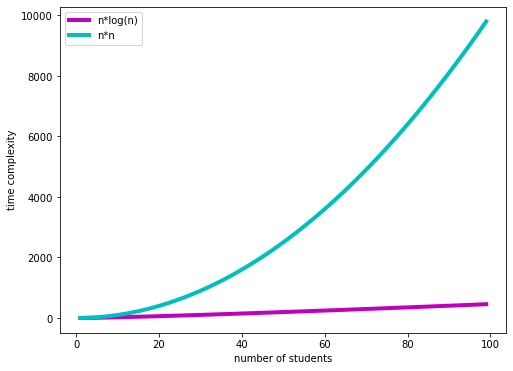

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import math

X = np.arange(1,100)
y = np.log(X)*X
z = X*X
plt.figure(figsize=(8, 6))
plt.plot(X, y, color='m', label='n*log(n)', linewidth=4.0)
plt.plot(X, z, color='c', label='n*n',linewidth=4.0)
plt.xlabel("number of students")
plt.ylabel("time complexity")
plt.legend()
plt.show()

In the previous plot there are the functions $nlog(n)$ and $n^2$ where n is the number of students.    
We've decided to show this plot in order to let you visualize the great gap that we have between the two functions when $n$ is large. In particular we can notice that the more n grows the more the gap increases.    
We can assert that if we have to sort a lot of elements is always better to use an algorithm that has a computational time of $nlog(n)$.

#### 3. Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

As we've seen before the times taken by the different algorithm are:
- **insertion sort**: 5.0 minutes and 12.51 seconds
- **merge sort**: 0.0 minutes and 0.67 seconds
- **quick sort**: 0.0 minutes and 35.89 seconds

Now we are going to study how the computational cost for these 3 sorting algorithms varias as the number of operations, and thus the number of data to be analyzed: obviously the algorithm will require more time if the data are more, but the increase will be different for the tree considered functions.

we repeat insertion sort, mergesort, and quicksort repeatedly on sublists of our original list of 50000 data, and each time we save our execution time. for the first try we use 5 sublists.

I will then eventually have a list of n (in the first case 5) times where in position 1 i have the time considered for 50000/n data, in second position (50000/n)x2 data, until i have in last position all 50000 data.

In [31]:
d,n,m = read_file()

In [40]:
def times_insertion(d):
    times_insertion = []
    for t in range(10000,len(d)+1,10000):
        dati_time = d[0:t]
        start_time = time.time()
        insertion_sort(dati_time,t)
        end_time = time.time()
        times_insertion.append(end_time-start_time)
    return times_insertion

In [41]:
times_i = times_insertion(d)

In [33]:
def times_merge(d):
    times_merge = []
    for t in range(10000,len(d)+1,10000):
        dati_time = d[0:t]
        start_time = time.time()
        merge_sort(dati_time,1,t)
        end_time = time.time()
        times_merge.append(end_time-start_time)
    return times_merge

In [34]:
times_m = times_merge(d)

In [36]:
def timesQuick(d):
    times_quick = []
    for t in range(10000,len(d)+1,10000):
        dati_time = d[0:t]
        start_time = time.time()
        quicksort(dati_time,0,t-1)
        end_time = time.time()
        times_quick.append(end_time-start_time)
    return times_quick

In [37]:
times_q = timesQuick(d)

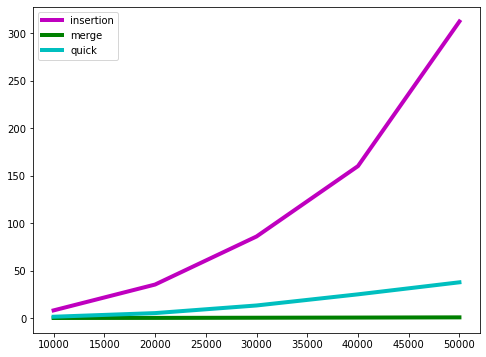

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import math

X = np.arange(10000,50000+1,10000)
ins = np.array(times_i)
mer = np.array(times_m)
qui = np.array(times_q)
plt.figure(figsize=(8, 6))
plt.plot(X, ins, color='m',label='insertion',linewidth=4.0)
plt.plot(X, mer, color='g',label='merge',linewidth=4.0)
plt.plot(X, qui, color='c',label='quick',linewidth=4.0)
plt.legend()
plt.show()

in the graph there are the 3 sorting algorithm (insertion, merge and quick) and their time trend with the increase of number of students to be analyzed.

#### 4. What is the most optimal algorithm, in your opinion, and why?

If we have to take a decision considering only the execution time of the algorithm we may say that the merge sort is the best one since it's the faster one.  
But even quick sort when we are not in particular case is a good one because it has a plus over merge sort.   
In fact even if merge sort is very fast we can notice that in the function merge we can't reorder the list without creating a new list in which store temporarily the new sorted elements and so we use more memory. Instead in the quick sort we can sort all the elements in loco.   
For this reason if we are in the cases in which quick sort takes a time complexity of $nlog(n)$ it's the best one to use.

#### 5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.

In [48]:
global dati
dati,n,m = read_file()

l = [1,n]

def mapR(list):
    start = list[0]
    end = list[1]
    if start<end:
        medium = (start+end)//2
        map(mapR, [[start, medium], [medium+1,end]])
        reduce(start,medium,end)
    return

def reduce(start,medium,end):
    B = []
    # since when we call the function mapR for the first time we give to it start=1 and end=n, we now need to fix indexes
    i = start-1
    j = medium
    while ((i<medium) and (j<end)):
        if dati[i][2]<dati[j][2]:
            B.append(dati[j])
            j+=1
        elif dati[i][2]>dati[j][2]:
            B.append(dati[i])
            i+=1
        elif dati[i][2]==dati[j][2]:
            if dati[i][0]==dati[j][0]:
                y_n = sort_by_name(dati[i][1],dati[j][1])
            elif dati[i][0]!=dati[j][0]:
                y_n = sort_by_name(dati[i][0],dati[j][0])
            if y_n==1:
                B.append(dati[i])
                i+=1
            elif y_n==0:
                B.append(dati[j])
                j+=1
    
    while i<medium:
        B.append(dati[i])
        i+=1
    while j<end:
        B.append(dati[j])
        j+=1
    if B !=[]:
        for k in range(0,end-start+1):
            dati[start-1+k]=B[k]
    return

In [49]:
mapR(l)